In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 
from geopy.distance import geodesic 
from pyresample.kd_tree import resample_nearest
from scipy import spatial

####################you will need to change some paths here!#####################
#list of input files
#list of input files

filename_aviso='F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106.nc'   #From AVISO  website
filename_bird='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide.csv'
#output files
filename_bird_out='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_with_sat_and eddy_data.csv'
filename_bird_out_netcdf='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_and_eddy_data.nc'
#################################################################################
filename_bird_out_eddy_netcdf='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_with_eddy.nc'

In [ ]:
#read in csv file in to panda dataframe & into xarray
df_bird = pd.read_csv(filename_bird)
ds_bird = df_bird.to_xarray()
#calculate time
ilen_bird = len(ds_bird.Lat)
ds_bird['time'] = xr.DataArray(np.empty(ilen_bird, dtype='datetime64[ns]'), coords={'index': ds_bird.index}, dims=('index'))
for i in range(len(df_bird)):
    tstr = str(df_bird.Year[i])+'-'+str(df_bird.Month[i]).zfill(2)+'-'+str(df_bird.Day[i]).zfill(2)
    ds_bird['time'][i]=np.datetime64(tstr)
ds_bird = ds_bird.rename({'Lat':'lat','Lon':'lon'})
ds_bird

In [ ]:
#just check lat/lon & see looks okay
minlat,maxlat=ds_bird.lat.min(),ds_bird.lat.max()
minlon,maxlon=ds_bird.lon.min(),ds_bird.lon.max()
plt.scatter(ds_bird.lon,ds_bird.lat)
print(minlat,maxlat,minlon,maxlon)

In [ ]:
#open aviso eddy dataset
ds = xr.open_dataset(filename_aviso).rename({'latitude':'lat','longitude':'lon'})
ds['lon'] = (ds.lon + 180) % 360 - 180
ds.close()
ds_eddy = ds
cond = (ds_eddy.lat>=minlat) & (ds_eddy.lat<=maxlat) & (ds_eddy.lon>=minlon) & (ds_eddy.lon<=maxlon)
ds_eddy = ds_eddy.where(cond,drop=True)
ilen_eddy = len(ds_eddy.lat)
print(ilen_eddy)
ds_eddy['time64'] = xr.DataArray(np.empty(ilen_eddy, dtype='datetime64[ns]'), coords={'obs': ds_eddy.obs}, dims=('obs'))
for i in range(ilen_eddy):
    ss = str(ds_eddy.time[i].dt.year.data)+'-'+str(ds_eddy.time[i].dt.month.data).zfill(2)+'-'+str(ds_eddy.time[i].dt.day.data).zfill(2)
    tem = np.datetime64(ss)
    ds_eddy['time64'][i]=tem
ds_eddy.to_netcdf('F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106_northpac.nc')

In [ ]:
ds_eddy = xr.open_dataset('F:/data/project_data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106_northpac.nc')
ilen_eddy = len(ds_eddy.lat)
plt.scatter(ds_eddy.lon,ds_eddy.lat)

In [ ]:
ds_eddy

In [ ]:
## print(len(cpr_sample_lat),ilen_cpr)
#print(len(lats_new),ilen_eddy)
save_eddy_index=[0] * (ilen_bird)
save_eddy_distance=[0] * (ilen_bird)

ilen_bird = len(ds_bird.lat)
ds_bird_save = ds_bird.copy(deep=True)
ilen_bird = len(ds_bird_save.lat)
for var in ds_eddy:
    if (var=='time'):
        continue
    if (var=='lat') or (var=='lon'):
        ds_bird_save[var+'_eddy']=xr.DataArray(np.empty(ilen_bird, dtype=str(ds_eddy[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
    else:
        ds_bird_save[var]=xr.DataArray(np.empty(ilen_bird, dtype=str(ds_eddy[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
ds_bird_save['save_eddy_distance']=xr.DataArray(np.empty(ilen_bird, dtype='float32'), coords={'index': ds_bird.index}, dims=('index'))

print(ilen_bird,ilen_eddy)
icnt=0
for index_bird in range(ilen_bird):
    if ds_bird.time[index_bird]<np.datetime64('1993-01-01'):
        continue
    arclen_to_eddy=100000  #set to a high value  
    iarg = np.argwhere(ds_eddy.time64.data==ds_bird.time[index_bird].data)
    if len(iarg)<1:
        continue
    for index_eddy in iarg:
        ieddy = int(index_eddy)
        coords_1 = (ds_bird.lat[index_bird], ds_bird.lon[index_bird])  #cpr sample location
        coords_2 = (ds_eddy.lat[ieddy], ds_eddy.lon[ieddy])  #eddy location
        arclen_temp = geodesic(coords_1, coords_2).km
        if arclen_temp<arclen_to_eddy:
            arclen_to_eddy=arclen_temp
            for var in ds_eddy:
                if (var=='time'):
                    continue
                if (var=='lat') or (var=='lon'):
                    ds_bird_save[var+'_eddy'][index_bird]=ds_eddy[var][ieddy]
                else:
                    ds_bird_save[var][index_bird]=ds_eddy[var][ieddy]
#                if var=='time':
#                    continue
#                ds_bird_save[var][index_bird]=ds_eddy[var][ieddy]
#            save_eddy_index[index_bird]=index_eddy
            ds_bird_save.save_eddy_distance[index_bird]=arclen_temp
            save_eddy_distance[index_bird]=arclen_temp
    if 20000*int(index_bird/20000)==index_bird:
        print(index_bird,ilen_bird)
ds_bird_save.to_netcdf(filename_bird_out_eddy_netcdf)

In [ ]:
plt.scatter(ds_bird_save.lat,ds_bird_save.lon)

In [ ]:
ds_bird_save

# Define function to read in data and put in a dictionary

In [ ]:
#define function to get all the data at once, use same years for climatology for all data
def get_data():
    
    #climatology years
    cyr1,cyr2='1993-01-01','2018-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_ccmp = ds.sortby(ds.lon)
    ds_ccmp = ds_ccmp.drop('nobs')
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    # AVISO test
    dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_aviso = ds.sortby(ds.lon).drop({'lat_bnds','lon_bnds','crs','err'})
    for var in ds_aviso:
        tem = ds_aviso[var].attrs
        tem['var_name']='aviso_'+str(var)
        ds_aviso[var].attrs=tem
    ds_aviso_clim = ds_aviso.sel(time=slice(cyr1,cyr2))
    ds_aviso_clim = ds_aviso_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)    

    #sst
    dir_pattern_zarr = 'F:/data/sat_data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #get bathymetry from ETOPO1
    fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
    ds = xr.open_dataset(fname_topo)
    ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})
    tem = ds_topo.z.attrs
    tem['var_name']='etopo_depth'
    ds_topo.z.attrs=tem

    #put data into a dictionary
    data_dict={'aviso':ds_aviso,
               'wnd':ds_ccmp,
               'sst':ds_sst,
              'topo':ds_topo}
    clim_dict={'aviso_clim':ds_aviso_clim,
               'wnd_clim':ds_ccmp_clim,
               'sst_clim':ds_sst_clim}
  
    return data_dict,clim_dict

In [ ]:
data,clim = get_data()

# Collocate all data with bird data

In [ ]:
#output files
ds_bird = xr.open_dataset(filename_bird_out_eddy_netcdf)
for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
    print('name',name)   
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.empty(ilen_bird, dtype=str(ds_data[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(80000,80100):
#    for i in range(len(ds_bird.lat)):
        if ds_bird.time[i]<ds_data.time.min():
            continue
        if ds_bird.time[i]>ds_data.time.max():
            continue
        t1,t2 = ds_bird.time[i]-np.timedelta64(24,'h'), ds_bird.time[i]+np.timedelta64(24,'h')
        lat1,lat2=ds_bird.lat[i]-.5,ds_bird.lat[i]+.5
        lon1,lon2=ds_bird.lon[i]-.5,ds_bird.lon[i]+.5
        tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
        tem = tem.interp(time=ds_bird.time[i],lat=ds_bird.lat[i],lon=ds_bird.lon[i])
        #tem = tem.load()
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']
            ds_bird[var_tem][i]=tem[var].data
        if int(i/10000)*10000==i:
            print(i,len(ds_bird.lat))
#at topo info
#interp will create a new 2D array, to avoid that put the lat/lon into dataarrays
ds_topo=data['topo']
new_lat = xr.DataArray(ds_bird.lat.data, dims='z')
new_lon = xr.DataArray(ds_bird.lon.data, dims='z')
tem = ds_topo.z.interp(lat=new_lat, lon=new_lon,method='nearest')
ds_bird['ETOPO_depth'] = xr.DataArray(tem.data, coords={'index': ds_bird.index}, dims=('index'))
ds_bird = ds_bird.drop('obs')

#output data
df_bird = ds_bird.to_dataframe()
df_bird.to_csv(filename_bird_out)
ds_bird.to_netcdf(filename_bird_out_netcdf)

# bring data together

In [ ]:
plt.plot(ds_bird.amplitude)

In [ ]:
adir = 'F:/data/project_data/NASA_biophysical/collocated_data/'
file1 = adir+'NPPSD_GOA_allseabird_wide_sat_and_eddy_data.ncaviso.nc'
file2 = adir+'NPPSD_GOA_allseabird_wide_sat_and_eddy_data.ncwnd.nc'
file3 = adir+'NPPSD_GOA_allseabird_wide_sat_and_eddy_data.ncsst.nc'

ds = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)
for var in ds2:
    if not var in ds:
        ds[var]=ds2[var]
ds2 = xr.open_dataset(file3)
for var in ds2:
    if not var in ds:
        ds[var]=ds2[var]
        
ds_topo=data['topo']
new_lat = xr.DataArray(ds.lat.data, dims='z')
new_lon = xr.DataArray(ds.lon.data, dims='z')
tem = ds_topo.z.interp(lat=new_lat, lon=new_lon,method='nearest')
ds['ETOPO_depth'] = xr.DataArray(tem.data, coords={'index': ds_bird.index}, dims=('index'))
#ds_bird = ds_bird.drop('obs')
         
ds.to_netcdf(adir+'NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.nc')
df_bird = ds.to_dataframe()
df_bird.to_csv(adir+'NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.csv')



# add distance from land

In [ ]:
ds_land = xr.open_dataset('f:/data/sat_data/distance_to_land_25km.nc')
ds_land

In [ ]:
adir = 'F:/data/project_data/NASA_biophysical/collocated_data/'
ds = xr.open_dataset(adir+'NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.nc')
new_lat = xr.DataArray(ds.lat.data, dims='z')
new_lon = xr.DataArray(ds.lon.data, dims='z')
tem = ds_land.dist_land.interp(lat=new_lat, lon=new_lon,method='nearest')
ds['distance_to_land'] = xr.DataArray(tem.data, coords={'index': ds_bird.index}, dims=('index'))


# new distance from land file

ValueError: at least one array or dtype is required

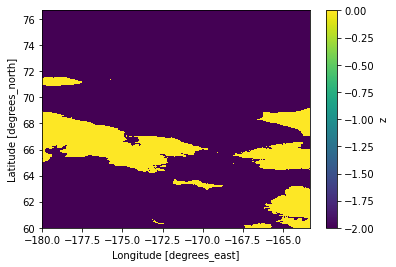

In [3]:
from geopy.distance import geodesic 
fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
ds = xr.open_dataset(fname_topo)
ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})
#create land mask -2 == ocean  0 == land
land_mask = ds_topo.where(ds_topo.z>=0,other=-1)
land_mask = land_mask/np.abs(land_mask)-1.
land_mask.z[9000:10000,0:1000].plot()
stacked = land_mask.stack(z=("lat", "lon"))
#only include land points
land = stacked.where(stacked>=0,drop=True)
# build the tree
lats = land.lat.data
lons = land.lon.data
inputdata = list(zip(lons.ravel(), lats.ravel()))
tree = spatial.KDTree(inputdata)
xlat = np.arange(-90,90,0.01)
xlon = np.arange(-180,180,0.01)
dist = land_mask.interp(lat=xlat,lon=xlon,method='nearest')
for nlat in xlat:
    for nlon in xlon:
        if dist[nlon,nlat]==0:   #land so distance == 0
            continue            #skip forward since already find land
        pts = np.array([nlon, nlat]) #pts = np.array([ds_usv.lon[iusv]+360
        tree.query(pts,k=1)
        i = tree.query(pts)[1]
        rdist = tree.query(pts)[0]
        dist[nlon,nlat]=rdist

# now add clim data

In [ ]:
#read in csv file in to panda dataframe
ds_bird = pd.read_csv(filename_bird_out)
#calculate time
tem=np.ones(len(ds_bird),dtype='datetime64[ns]')
for i in range(len(ds_bird)):
    tstr = str(ds_bird.Year[i])+'-'+str(ds_bird.Month[i]).zfill(2)+'-'+str(ds_bird.Day[i]).zfill(2)
    tem[i]=np.datetime64(tstr)
ds_bird['time']=tem
ds_bird

In [ ]:
for name in clim:
    ds_data=clim[name]
    print('name',name)
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']+'_clim'
        ds_bird[var_tem]=np.ones(len(ds_bird))*np.NaN
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(len(ds_bird)):
        t1,t2 = ds_bird.time[i]-np.timedelta64(24,'h'), ds_bird.time[i]+np.timedelta64(24,'h')
        lat1,lat2=ds_bird.Lat[i]-.5,ds_bird.Lat[i]+.5
        lon1,lon2=ds_bird.Lon[i]-.5,ds_bird.Lon[i]+.5
        tem = ds_data.sel(dayofyear=ds_bird.time[i].dayofyear,lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
        tem = tem.interp(lat=ds_bird.Lat[i],lon=ds_bird.Lon[i])
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']+'_clim'
            ds_bird[var_tem][i]=tem[var].data
            
#output data
ds_bird.to_csv(filename_bird_out_final)
DS_bird = xr.Dataset.from_dataframe(ds_bird)
DS_bird.to_netcdf(filename_bird_out_netcdf_final)


